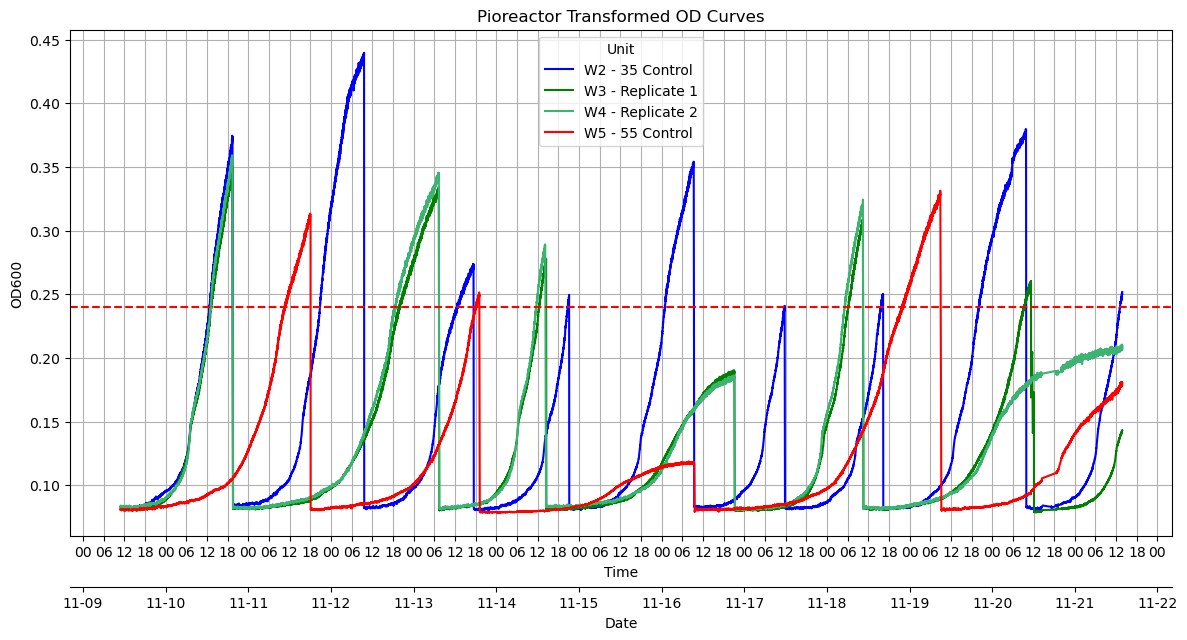

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np
import matplotlib.dates as mdates

# Get the list of CSV files in the Downloads folder
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))

if len(csv_files) == 0:
    csv_files = glob.glob('./od_logs/*.csv')

# Find the most recent file based on modification time
latest_csv = max(csv_files, key=os.path.getmtime)

# Load the CSV file
df = (
    pd.read_csv(latest_csv)
    .rename(columns={"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
    .drop(columns=["experiment", "timestamp", "angle", "channel"])
    .assign(Time=lambda d: pd.to_datetime(d["Time"]))  # Convert 'Time' to datetime
)

# Dictionary to map 'Pioreactor name' to new values
name_dict = {
    'worker2': 'W2 - 35 Control',
    'worker3': 'W3 - Replicate 1',
    'worker4': 'W4 - Replicate 2',
    'worker5': 'W5 - 55 Control'
}
# Replace values in 'Pioreactor name' column using the dictionary
df['Unit'] = df['Unit'].replace(name_dict)

threshold_od = 0.24

# Filter the DataFrame to only include data after 100 measurements and OD600 values less than 1
df = df[df.index >= 100]
df = df[df['OD600'] < 1]

# Drop duplicate entries based on Time and Unit before pivoting
df = df.drop_duplicates(subset=['Time', 'Unit'])

# Pivot the DataFrame to have Units as columns and Time as the index
df = df.pivot(index='Time', columns='Unit', values='OD600').resample('min').mean()

# Define the corresponding transformations for each condition
equations = {
    'W2 - 35 Control': (1.348628103, 0.077),
    'W3 - Replicate 1': (2.073660771, 0.077),
    'W4 - Replicate 2': (2.204291876, 0.077),
    'W5 - 55 Control': (1.169484467, 0.077)
}

# Apply the transformations
for unit, (slope, intercept) in equations.items():
    if unit in df.columns:
        df[unit] = df[unit] * slope + intercept

# Plot the DataFrame'
f, ax = plt.subplots(figsize=(12, 6.5))
sns.lineplot(data=df, dashes=False, ax=ax, palette=["blue", "green", "mediumseagreen", "red"])
plt.xlabel('Time')
plt.ylabel('OD600')
plt.legend(title='Unit')
plt.title('Pioreactor Transformed OD Curves')

# Add a horizontal line for the threshold OD value
plt.axhline(y=threshold_od, color='r', linestyle='--')

# Set major ticks to every 6 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
# Create a secondary x-axis for date display
secax = ax.secondary_xaxis(-0.1)
secax.xaxis.set_major_locator(mdates.DayLocator())
secax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
secax.set_xlabel("Date")

plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Get the list of CSV files in the Downloads folder
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))

if len(csv_files) == 0:
    csv_files = glob.glob('./od_logs/*.csv')

# Find the most recent file based on modification time
latest_csv = max(csv_files, key=os.path.getmtime)


# Load, process, and downsample the CSV file
df = (
    pd.read_csv(latest_csv)
    .rename(columns={"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
    .drop(columns=["experiment", "timestamp", "angle", "channel"])
    .assign(Time=lambda d: pd.to_datetime(d["Time"]))  # Convert 'Time' to datetime
)

# Set 'Time' as the index
df = df.set_index('Time')

# Calculate the rolling difference between consecutive OD600 values
rolling_diff = df['OD600'].diff().abs()

# Filter out rows where the difference from the surrounding points exceeds 0.5
df = df[rolling_diff <= 0.5]

# Downsample each unit to one point per minute
downsampled_df = df.groupby('Unit').resample('min').mean().dropna().reset_index()

# Convert 'Time' to minutes starting from 0
min_time = downsampled_df['Time'].min()  # Get the earliest time
downsampled_df['Time'] = ((downsampled_df['Time'] - min_time).dt.total_seconds() / 60).astype(int)  # Convert to minutes

# Rename the column for clarity
downsampled_df = downsampled_df.rename(columns={'Time': 'Min'})

# Define the corresponding transformations for each condition
equations = {
    "worker2": (1.348628103, 0.077),
    "worker3": (2.073660771, 0.077),
    "worker4": (2.204291876, 0.077),
    "worker5": (1.169484467, 0.077)
}

# Apply the transformations to the OD600 values based on the unit
def calibrate_od(row):
    if row['Unit'] in equations:
        a, b = equations[row['Unit']]
        return a * row['OD600'] + b
    return row['OD600']  # Return original value if unit is not in the equations

# Apply the calibration function
downsampled_df['OD600_calibrated'] = downsampled_df.apply(calibrate_od, axis=1)

# Pivot the DataFrame to have Units as columns and Min as the index
pivoted_df = downsampled_df.pivot(index='Min', columns='Unit', values='OD600_calibrated')

# Cut the first 5 minutes of the DataFrame
pivoted_df = pivoted_df[pivoted_df.index >= 5]

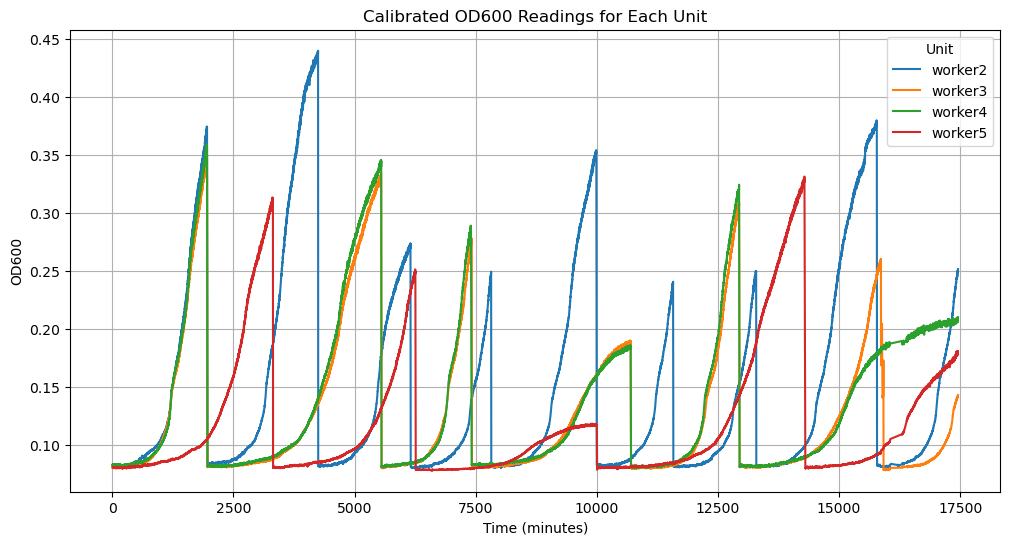

In [10]:
# Plot the calibrated OD600 readings for each unit
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivoted_df, dashes=False)
plt.xlabel('Time (minutes)')
plt.ylabel('OD600')
plt.title('Calibrated OD600 Readings for Each Unit')
plt.legend(title='Unit')
plt.grid(True)
plt.tight_layout
plt.show()
